In [1]:
from eyring_model import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import pandas as pd
import seaborn as sns

# some constants
kB = 1.380649 * 10**-23    # Boltzmann (m^2 kg / s^2 K)
h = 6.62607 * 10**-34      # Planck (m^2 kg / s)
R = 1.9858775 * 10**-3     # universal gas (kcal / mol K)

In [36]:
# read in the experimental data
df = pd.read_csv('experimental_data.csv')
df1 = df[df['system'] == 'NaCl (NF270)']
T = df1['T (K)']
P_experiment = df1['ave B (m/sec)']
P_std = df1['SD B']

# make some guesses on parameters
delta = 200 # 200 Angstrom thickness
lam = 2 # 2 Angstrom jumps

In [44]:
sig_i = np.abs(P_std/P_experiment)
x_i = 1/T

D = np.sum(1/sig_i**2) * np.sum(x_i**2/sig_i**2) - (np.sum(x_i/sig_i**2))**2
sig_b = 1/D * np.sum(x_i**2/sig_i**2)
sig_m = 1/D * np.sum(1/sig_i**2)

sig_m, sig_b

(337890.5992812343, 3.8962785455116764)

$\ln{P} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{P} = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B T}{h} \right)} + \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B T}{h} \right)} + \frac{\Delta S_{eff}}{R}$

But, the intercept still has a temperature dependence...

In [35]:
# perform linear fit of ln(P) vs 1/T
X = sm.add_constant(1/T)
ols1 = sm.OLS(np.log(P_experiment), X)
results1 = ols1.fit()
b, m = results1.params
be, me = results1.bse # standard error 

print('ln(P) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for P at 305 K: {np.exp(m*(1/305) + b):.4e}')

print(results1.summary())

ln(P) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.11 +/- 0.18 kcal/mol
Arrhenius prefactor, ln(A): -3.43 +/- 0.31 A/s
Prediction for P at 305 K: 3.6439e-05
                            OLS Regression Results                            
Dep. Variable:          ave B (m/sec)   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     499.0
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           2.38e-05
Time:                        12:44:24   Log-Likelihood:                 14.647
No. Observations:                   6   AIC:                            -25.29
Df Residuals:                       4   BIC:                            -25.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

/home/nate/anaconda3/envs/mpi4py/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


$\ln{\frac{P}{T}} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{\frac{P}{T}} = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B}{h} \right)} + \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B}{h} \right)} + \frac{\Delta S_{eff}}{R}$

In [47]:
# perform linear fit of ln(P/T) vs 1/T
X = sm.add_constant(1/T)
ols2 = sm.OLS(np.log(P_experiment/T), X)
results2 = ols2.fit()
b, m = results2.params
be, me = results2.bse

print('ln(P/T) vs 1/T:')
print(f'Effective enthalpy to permeability: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Effective entropy with constants: {b*R:.4e} +/- {be*R:.2e} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

print(results2.summary())

ln(P/T) vs 1/T:
Effective enthalpy to permeability: 3.52 +/- 0.19 kcal/mol
Effective entropy with constants: -2.0116e-02 +/- 6.29e-04 A/s
Prediction for 305 K: -15.94
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     352.3
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           4.74e-05
Time:                        14:14:36   Log-Likelihood:                 14.536
No. Observations:                   6   AIC:                            -25.07
Df Residuals:                       4   BIC:                            -25.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t

/home/nate/anaconda3/envs/mpi4py/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


$\ln{\left( \frac{P \delta h}{\lambda^2 k_B T} \right)} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{\left( \frac{P \delta h}{\lambda^2 k_B T} \right)} = \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \frac{\Delta S_{eff}}{R}$

In [28]:
# perform linear fit of ln(P*delta*h/lam^2*kB*T) vs 1/T
X = sm.add_constant(1/T)
ols3 = sm.OLS(np.log(P_experiment*delta*h/lam**2/kB/T), X)
results3 = ols3.fit()
b, m = results3.params
be, me = results3.bse

print('ln(P*delta*h/lam^2*kB*T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P*delta*h/lam^2*kB*T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.43 +/- 0.76 kcal/mol
Arrhenius prefactor, ln(A): -31.06 +/- 1.29 A/s
Prediction for 305 K: -36.72


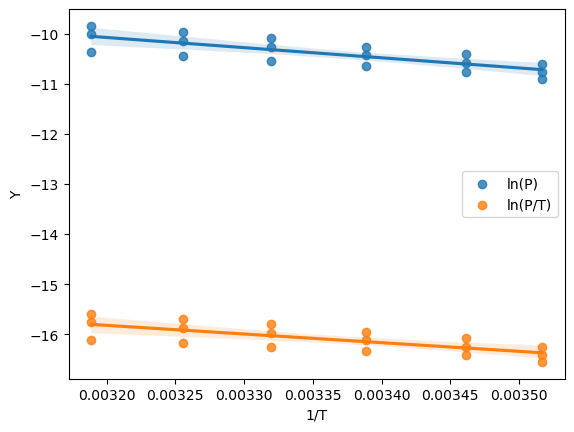

In [29]:
# plot the linear fits
df['1/T'] = 1/df['T (K)']
df['ln(P)'] = np.log(P_experiment)
df['ln(P/T)'] = np.log(P_experiment/T)
df['ln(CP/T)'] = np.log(P_experiment*delta*h/lam**2/kB/T)

fig, ax = plt.subplots(1,1)
sns.regplot(x='1/T', y='ln(P)', data=df, ax=ax, label='ln(P)', ci=95)
sns.regplot(x='1/T', y='ln(P/T)', data=df, ax=ax, label='ln(P/T)', ci=95)
# sns.regplot(x='1/T', y='ln(CP/T)', data=df, ax=ax, label='ln(C*P/T)')

plt.ylabel('Y')
plt.legend();

In [30]:
print(f'Sum of squared residuals for ln(P) vs 1/T: {results1.ssr}')
print(f'Sum of squared residuals for ln(P/T) vs 1/T: {results2.ssr}')

Sum of squared residuals for ln(P) vs 1/T: 0.5448210209390335
Sum of squared residuals for ln(P/T) vs 1/T: 0.5451251527821924


In [35]:
# now with the average permeabilities
df = pd.read_excel('../P_vs_T_results.xlsx')
df = df[df['system'] == 'NaCl (NF270)'].dropna()
T = df['T (K)']
P_experiment = df['ave B (m/sec)']

In [37]:
# perform linear fit of ln(P) vs 1/T
X = sm.add_constant(1/T)
ols1 = sm.OLS(np.log(P_experiment), X)
results1 = ols1.fit()
b, m = results1.params
be, me = results1.bse

print('ln(P) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

print(results1.summary())

ln(P) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.11 +/- 0.18 kcal/mol
Arrhenius prefactor, ln(A): -3.43 +/- 0.31 A/s
Prediction for 305 K: -10.22
                            OLS Regression Results                            
Dep. Variable:          ave B (m/sec)   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     499.1
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           2.38e-05
Time:                        12:32:03   Log-Likelihood:                 14.647
No. Observations:                   6   AIC:                            -25.29
Df Residuals:                       4   BIC:                            -25.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|    

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [38]:
# perform linear fit of ln(P/T) vs 1/T
X = sm.add_constant(1/T)
ols2 = sm.OLS(np.log(P_experiment/T), X)
results2 = ols2.fit()
b, m = results2.params
be, me = results2.bse

print('ln(P/T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

print(results2.summary())

ln(P/T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.52 +/- 0.19 kcal/mol
Arrhenius prefactor, ln(A): -10.13 +/- 0.32 A/s
Prediction for 305 K: -15.94
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     352.3
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           4.74e-05
Time:                        12:32:21   Log-Likelihood:                 14.536
No. Observations:                   6   AIC:                            -25.07
Df Residuals:                       4   BIC:                            -25.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t| 

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [39]:
# perform linear fit of ln(P*delta*h/lam^2*kB*T) vs 1/T
X = sm.add_constant(1/T)
ols3 = sm.OLS(np.log(P_experiment*delta*h/lam**2/kB/T), X)
results3 = ols3.fit()
b, m = results3.params
be, me = results3.bse

print('ln(P*delta*h/lam^2*kB*T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')
print(f'Prediction for 305 K: {m*(1/305) + b:.2f}')

ln(P*delta*h/lam^2*kB*T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.52 +/- 0.19 kcal/mol
Arrhenius prefactor, ln(A): -30.89 +/- 0.32 A/s
Prediction for 305 K: -36.70


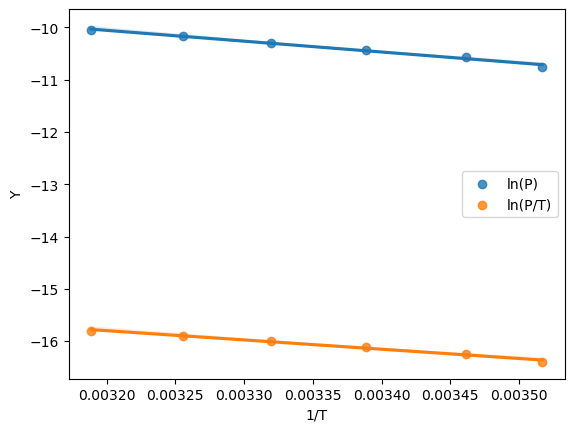

In [40]:
# plot the linear fits
df['1/T'] = 1/df['T (K)']
df['ln(P)'] = np.log(P_experiment)
df['ln(P/T)'] = np.log(P_experiment/T)
df['ln(CP/T)'] = np.log(P_experiment*delta*h/lam**2/kB/T)

fig, ax = plt.subplots(1,1)
sns.regplot(x='1/T', y='ln(P)', data=df, ax=ax, label='ln(P)', ci=95)
sns.regplot(x='1/T', y='ln(P/T)', data=df, ax=ax, label='ln(P/T)', ci=95)
# sns.regplot(x='1/T', y='ln(CP/T)', data=df, ax=ax, label='ln(C*P/T)')

plt.ylabel('Y')
plt.legend();

In [41]:
print(f'Sum of squared residuals for ln(P) vs 1/T: {results1.ssr}')
print(f'Sum of squared residuals for ln(P/T) vs 1/T: {results2.ssr}')

Sum of squared residuals for ln(P) vs 1/T: 0.0026625445905459357
Sum of squared residuals for ln(P/T) vs 1/T: 0.0027629163344016876
